# Octo Dataloading Examples

This notebook will walk you through some of the primary features of the Octo dataloader. Data is, after all, the most important part of any machine learning pipeline!

## Loading Open X-Embodiment Data

The [Open X-Embodiment (OXE)](https://robotics-transformer-x.github.io/) project was a massive cross-instutition data collection collaboration the likes of which robot learning has never seen before. The resulting dataset includes 22 different robots demonstrating 527 skills and totals over 1 million trajectories. However, as we found throughout the course of the Octo project, simply loading such a diverse set of robot data is no small feat. We hope that the `octo.data` pipeline can help kickstart anyone who hopes to take advantage of the massive collection of robot demonstrations that is OXE!

### Minimum working example to load a single OXE dataset

In [16]:
%reload_ext autoreload
# minimum working example to load a single OXE dataset
from octo.data.oxe import make_oxe_dataset_kwargs
from octo.data.dataset import make_single_dataset
from octo.data.utils.data_utils import pprint_dsdict, pprint_dict
from pprint import pprint


# dataset_name = "bridge"
# oxe_dir = "gs://gresearch/robotics"
oxe_dir = "/scr/shared/datasets/oxe"
dataset_name = "bridge_dataset"
# dataset_name = "fractal20220817_data"
oxe_embeddings_dir = "/scr/shared/datasets/oxe_dinov3_embeddings"

# see octo/data/oxe/oxe_dataset_configs.py for available datasets
dataset_kwargs = make_oxe_dataset_kwargs(
    dataset_name,
    oxe_dir,
    oxe_embeddings_dir=oxe_embeddings_dir,
    load_dinov3_embeddings=True,
    load_proprio=True,
)
pprint(dataset_kwargs)
dataset = make_single_dataset(
    dataset_kwargs,
    train=True,
)  # load the train split
iterator = dataset.iterator()
traj = next(iterator)
pprint_dsdict(traj)

{'action_normalization_mask': [True, True, True, True, True, True, False],
 'action_proprio_normalization_type': <NormalizationType.BOUNDS: 'bounds'>,
 'data_dir': '/scr/shared/datasets/oxe',
 'dinov3_embeddings_key': 'dinov3_embeddings',
 'discount': 0.98,
 'image_obs_keys': {'primary': 'image_0'},
 'language_key': 'language_instruction',
 'name': 'bridge_dataset',
 'num_final_repeat': 3,
 'oxe_embeddings_dir': '/scr/shared/datasets/oxe_dinov3_embeddings',
 'proprio_obs_key': 'proprio',
 'standardize_fn': {'args': (),
                    'kwargs': {},
                    'module': 'octo.data.oxe.oxe_standardization_transforms',
                    'name': 'bridge_dataset_transform'}}


Shape reminder:
	image_*: (T or B, history, H, W, C)
	action: (T or B, history, horizon, A)

Top-level keys: dict_keys(['observation', 'task', 'tfds_id', 'action', 'dataset_name', 'reward', 'td_mask', 'mc_return', 'embeddings', 'action_pad_mask', 'next_action', 'next_observation'])

observation:
  .image_primary: shape=(25, 1, 256, 256, 3); uint8
  .proprio: shape=(25, 1, 7); float32
  .timestep: shape=(25, 1); int32
  .pad_mask_dict: (dict)
    .pad_mask_dict.image_primary: shape=(25, 1); bool
    .pad_mask_dict.proprio: shape=(25, 1); bool
    .pad_mask_dict.timestep: shape=(25, 1); bool
  .timestep_pad_mask: shape=(25, 1); bool
  .task_completed: shape=(25, 1, 1); bool

task:
  .language_instruction: shape=(25,); object
  .pad_mask_dict: (dict)
    .pad_mask_dict.language_instruction: shape=(25,); bool

tfds_id:
  : shape=(25,); object

action:
  : shape=(25, 1, 1, 7); float32

dataset_name:
  : shape=(25,); object

reward:
  : shape=(25,); float32

td_mask:
  : shape=(25,); float32

In [ ]:
import tensorflow_datasets as tfds

DATASET_NAMES = [
    "bridge_dataset",
    "fractal20220817_data",
    "language_table",
    "toto",
    "cmu_stretch",
    "berkeley_cable_routing",
    "austin_sirius_dataset_converted_externally_to_rlds",
    "berkeley_autolab_ur5",
    "jaco_play",
    "nyu_door_opening_surprising_effectiveness",
    "utaustin_mutex",
    "taco_play",
    "ucsd_kitchen_dataset_converted_externally_to_rlds",
    "kuka",
    "nyu_franka_play_dataset_converted_externally_to_rlds",
    "stanford_hydra_dataset_converted_externally_to_rlds",
    "bc_z",
    "dlr_edan_shared_control_converted_externally_to_rlds",
    "furniture_bench_dataset_converted_externally_to_rlds",
    "viola",
    "austin_sailor_dataset_converted_externally_to_rlds",
    "iamlab_cmu_pickup_insert_converted_externally_to_rlds",
    "roboturk",
    "berkeley_fanuc_manipulation",
    "austin_buds_dataset_converted_externally_to_rlds",
]
max_ds_name_len = len(max(DATASET_NAMES, key=len))
for name in DATASET_NAMES:
    builder = tfds.builder(name, data_dir=oxe_dir)
    split_keys = list(builder.info.splits.keys())
    print(f"{name:{max_ds_name_len}} has {len(split_keys)} splits: {split_keys}")
    # for split in split_keys:
    #     print(f"  {split}: {builder.info.splits[split].num_examples}")


bridge_dataset                                        has 2 splits: ['train', 'val']
fractal20220817_data                                  has 1 splits: ['train']
language_table                                        has 1 splits: ['train']
toto                                                  has 2 splits: ['train', 'test']
cmu_stretch                                           has 1 splits: ['train']
berkeley_cable_routing                                has 2 splits: ['train', 'test']
austin_sirius_dataset_converted_externally_to_rlds    has 1 splits: ['train']
berkeley_autolab_ur5                                  has 2 splits: ['train', 'test']
jaco_play                                             has 2 splits: ['train', 'test']
nyu_door_opening_surprising_effectiveness             has 2 splits: ['train', 'test']
utaustin_mutex                                        has 1 splits: ['train']
taco_play                                             has 2 splits: ['train', 'test']
ucsd_kitc

In [ ]:
# next_observation is just the observation offset by 1
imgs = traj["observation"]["image_primary"]
imgs_next = traj["next_observation"]["image_primary"]
print("(T, hist, H, W, C)")
print(imgs.shape)
print(imgs_next.shape)
print(np.all(imgs == imgs_next))

print("\n(hist, H, W, C)")
img = imgs[1]
next_img = imgs_next[0]
print(img.shape)
print(next_img.shape)
print(np.all(img == next_img))

print("\n(T, hist, H, W, C)")
imgs = imgs[1:]
next_imgs = imgs_next[:-1]
print(imgs.shape)
print(next_imgs.shape)
print(np.all(imgs == next_imgs))

(T, hist, H, W, C)
(17, 1, 256, 256, 3)
(17, 1, 256, 256, 3)
False

(hist, H, W, C)
(1, 256, 256, 3)
(1, 256, 256, 3)
True

(T, hist, H, W, C)
(16, 1, 256, 256, 3)
(16, 1, 256, 256, 3)
True


(28, 1, 256, 256, 3)
(28, 1, 256, 256, 3)


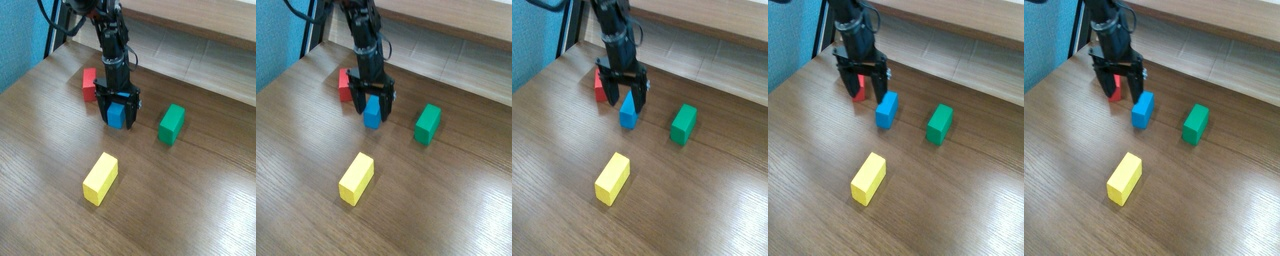

In [3]:
from PIL import Image
import numpy as np

traj = next(iterator)
images = traj["observation"]["image_primary"]
next_images = traj["next_observation"]["image_primary"]
# should be: (traj_len, window_size, height, width, channels)
# (window_size defaults to 1)
print(images.shape)
Image.fromarray(np.concatenate(images.squeeze()[-5:], axis=1))  # last 5 frames
print(next_images.shape)
Image.fromarray(np.concatenate(next_images.squeeze()[-5:], axis=1))  # last 5 frames

(64, 1, 256, 256, 3)


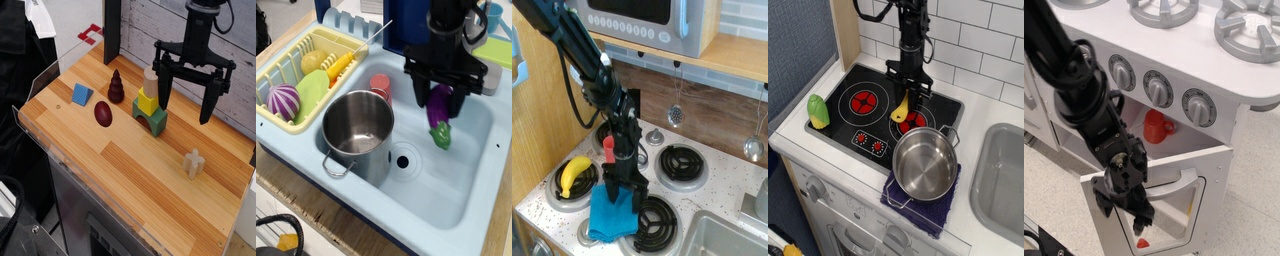

In [4]:
# you should set these much higher in practice (as large as your memory can hold!)
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 64

# turning a dataset of trajectories into a training-ready batched dataset
train_dataset = (
    dataset.flatten()  # flattens trajectories into individual frames
    .shuffle(SHUFFLE_BUFFER_SIZE)  # shuffles the frames
    .batch(BATCH_SIZE)  # batches the frames
)
batch = next(train_dataset.iterator())
images = batch["observation"]["image_primary"]
# should be: (batch_size, window_size, height, width, channels)
print(images.shape)
Image.fromarray(
    np.concatenate(images.squeeze()[:5], axis=1)
)  # first 5 batch elements, each is a window of 1 frame

In [5]:
pprint_dsdict(batch)
print(batch["tfds_id"])


Shape reminder:
	image_*: (T or B, history, H, W, C)
	action: (T or B, history, horizon, A)

Top-level keys: dict_keys(['observation', 'task', 'tfds_id', 'action', 'dataset_name', 'reward', 'td_mask', 'mc_return', 'embeddings', 'action_pad_mask', 'next_action', 'next_observation'])

observation:
  .image_primary: shape=(64, 1, 256, 256, 3); uint8
  .proprio: shape=(64, 1, 7); float32
  .timestep: shape=(64, 1); int32
  .pad_mask_dict: (dict)
    .pad_mask_dict.image_primary: shape=(64, 1); bool
    .pad_mask_dict.proprio: shape=(64, 1); bool
    .pad_mask_dict.timestep: shape=(64, 1); bool
  .timestep_pad_mask: shape=(64, 1); bool
  .task_completed: shape=(64, 1, 1); bool

task:
  .language_instruction: shape=(64,); object
  .pad_mask_dict: (dict)
    .pad_mask_dict.language_instruction: shape=(64,); bool

tfds_id:
  : shape=(64,); object

action:
  : shape=(64, 1, 1, 7); float32

dataset_name:
  : shape=(64,); object

reward:
  : shape=(64,); float32

td_mask:
  : shape=(64,); float32

### Loading a training-ready OXE mix

In reality, you're probably going to want to mix multiple datasets together, as well as use other transformations such as resizing, augmentation, windowing, etc. This section will show you how to get a proper OXE mix up and running, as well as demonstrate additional `octo.data` features for more realistic use-cases.

In [11]:
from octo.data.oxe import make_oxe_dataset_kwargs_and_weights
from octo.data.dataset import make_interleaved_dataset

dataset_kwargs_list, sample_weights = make_oxe_dataset_kwargs_and_weights(
    # you can pass your own list of dataset names and sample weights here, but we've
    # also provided a few named mixes for convenience. The Octo model was trained
    # using the "oxe_magic_soup" mix.
    "bridge",
    # can be local or on cloud storage (anything supported by TFDS)
    oxe_dir,
    # let's get a wrist camera!
    load_camera_views=("primary", "wrist"),
    load_proprio=True,
    oxe_embeddings_dir=oxe_embeddings_dir,
    load_dinov3_embeddings=True,
)

# see `octo.data.dataset.make_dataset_from_rlds` for the meaning of these kwargs
dataset_kwargs_list[0]

{'name': 'bridge_dataset',
 'data_dir': '/scr/shared/datasets/oxe',
 'oxe_embeddings_dir': '/scr/shared/datasets/oxe_dinov3_embeddings',
 'image_obs_keys': {'primary': 'image_0', 'wrist': None},
 'action_normalization_mask': [True, True, True, True, True, True, False],
 'proprio_obs_key': 'proprio',
 'language_key': 'language_instruction',
 'dinov3_embeddings_key': 'dinov3_embeddings',
 'action_proprio_normalization_type': <NormalizationType.NORMAL: 'normal'>,
 'standardize_fn': {'module': 'octo.data.oxe.oxe_standardization_transforms',
  'name': 'bridge_dataset_transform',
  'args': (),
  'kwargs': {}},
 'discount': 0.98,
 'num_final_repeat': 3}

In [12]:
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 8
WINDOW_SIZE = 2
ACTION_HORIZON = 4
SUBSAMPLE_LENGTH = 100

traj_transform_kwargs = dict(
    goal_relabeling_strategy="uniform",  # let's get some goal images
    window_size=WINDOW_SIZE,  # let's get some history
    action_horizon=ACTION_HORIZON,  # let's get some future actions for action chunking
    subsample_length=SUBSAMPLE_LENGTH,  # subsampling long trajectories improves shuffling a lot
)

frame_transform_kwargs = dict(
    # let's apply some basic image augmentations -- see `dlimp.transforms.augment_image`
    # for full documentation of these configuration options
    image_augment_kwargs=dict(
        primary=dict(
            augment_order=["random_resized_crop", "random_brightness"],
            random_resized_crop=dict(scale=[0.8, 1.0], ratio=[0.9, 1.1]),
            random_brightness=[0.1],
        )
    ),
    # providing a `resize_size` is highly recommended for a mixed dataset, otherwise
    # datasets with different resolutions will cause errors
    resize_size=dict(
        primary=(256, 256),
        wrist=(128, 128),
    ),
    # If parallelism options are not provided, they will default to tf.Data.AUTOTUNE.
    # However, we would highly recommend setting them manually if you run into issues
    # with memory or dataloading speed. Frame transforms are usually the speed
    # bottleneck (due to image decoding, augmentation, and resizing), so you can set
    # this to a very high value if you have a lot of CPU cores. Keep in mind that more
    # parallel calls also use more memory, though.
    num_parallel_calls=64,
)

# each element of `dataset_kwargs_list` can be used with `make_single_dataset`, but let's
# use the more powerful `make_interleaved_dataset` to combine them for us!
dataset = make_interleaved_dataset(
    dataset_kwargs_list,
    sample_weights,
    train=True,
    # unlike our manual shuffling above, `make_interleaved_dataset` will shuffle
    # the JPEG-encoded images, so you should be able to fit a much larger buffer size
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    # see `octo.data.dataset.apply_trajectory_transforms` for full documentation
    # of these configuration options
    traj_transform_kwargs=traj_transform_kwargs,
    # see `octo.data.dataset.apply_frame_transforms` for full documentation
    # of these configuration options
    frame_transform_kwargs=frame_transform_kwargs,
    # Same spiel as above about performance, although trajectory transforms and data reading
    # are usually not the speed bottleneck. One reason to manually set these is if you want
    # to reduce memory usage (since autotune may spawn way more threads than necessary).
    traj_transform_threads=16,
    traj_read_threads=16,
)

# Another performance knob to tune is the number of batches to prefetch -- again,
# the default of tf.data.AUTOTUNE can sometimes use more memory than necessary.
iterator = dataset.iterator(prefetch=1)


######################################################################################
# Loading the following 1 datasets (incl. sampling weight):                         #
# bridge_dataset: ==========================================================1.000000 #
######################################################################################



W0000 00:00:1761090207.284982 1465902 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 256 } dim { size: 256 } dim { size: -26 } } } inputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -2 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 2450 num_cores: 128 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 268435456 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { size: -40 } dim { size: -41 } dim { size: -26 } } }
W0000 00:00:17610902

In [13]:
# phew, that was a lot of configuration! Let's see what we got.
batch = next(iterator)
print("Top-level keys: ", batch.keys())
# should now have "image_primary" and "image_wrist"!
print("Observation keys: ", batch["observation"].keys())
# should also have "image_primary" and "image_wrist", corresponding to future goal images
print("Task keys: ", batch["task"].keys())

Top-level keys:  dict_keys(['observation', 'task', 'tfds_id', 'action', 'dataset_name', 'reward', 'td_mask', 'mc_return', 'embeddings', 'action_pad_mask', 'next_action', 'next_observation'])
Observation keys:  dict_keys(['image_primary', 'image_wrist', 'proprio', 'timestep', 'pad_mask_dict', 'timestep_pad_mask', 'task_completed'])
Task keys:  dict_keys(['language_instruction', 'pad_mask_dict', 'image_primary', 'image_wrist', 'proprio', 'timestep'])


In [14]:
pprint_dsdict(batch)
print(batch["tfds_id"])

Shape reminder:
	image_*: (T or B, history, H, W, C)
	action: (T or B, history, horizon, A)

Top-level keys: dict_keys(['observation', 'task', 'tfds_id', 'action', 'dataset_name', 'reward', 'td_mask', 'mc_return', 'embeddings', 'action_pad_mask', 'next_action', 'next_observation'])

observation:
  .image_primary: shape=(8, 2, 256, 256, 3); uint8
  .image_wrist: shape=(8, 2, 128, 128, 3); uint8
  .proprio: shape=(8, 2, 7); float32
  .timestep: shape=(8, 2); int32
  .pad_mask_dict: (dict)
    .pad_mask_dict.image_primary: shape=(8, 2); bool
    .pad_mask_dict.image_wrist: shape=(8, 2); bool
    .pad_mask_dict.proprio: shape=(8, 2); bool
    .pad_mask_dict.timestep: shape=(8, 2); bool
  .timestep_pad_mask: shape=(8, 2); bool
  .task_completed: shape=(8, 2, 4); bool

task:
  .language_instruction: shape=(8,); object
  .pad_mask_dict: (dict)
    .pad_mask_dict.language_instruction: shape=(8,); bool
    .pad_mask_dict.image_primary: shape=(8,); bool
    .pad_mask_dict.image_wrist: shape=(8,)

In [ ]:
from PIL import Image
import numpy as np

images_primary = batch["observation"]["image_primary"]
images_wrist = batch["observation"]["image_wrist"]
# should be: (batch_size, window_size (now 2), height, width, channels)
print(images_primary.shape)
print(images_wrist.shape)
actions = batch["action"]
# should be: (batch_size, window_size, action_horizon, action_dim)
print(actions.shape)

(8, 2, 256, 256, 3)
(8, 2, 128, 128, 3)
(8, 2, 4, 7)


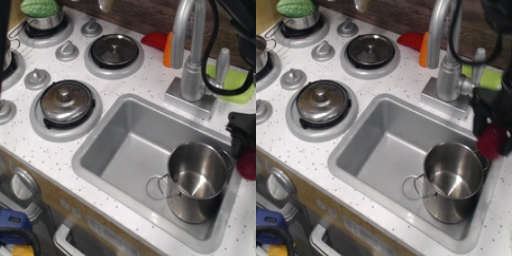

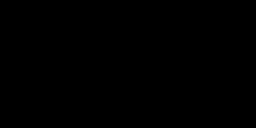

[False False]


In [ ]:
# let's visualize a window of primary images
display(Image.fromarray(np.concatenate(images_primary[0], axis=1)))
# now a window of wrist images -- many datasets don't have wrist images,
# so this will often be black
display(Image.fromarray(np.concatenate(images_wrist[0], axis=1)))
# pad_mask_dict also tells you which keys should be treated as padding
# (e.g., if the wrist camera is black, the corresponding pad_mask_dict entry is False)
print(batch["observation"]["pad_mask_dict"]["image_wrist"][0])

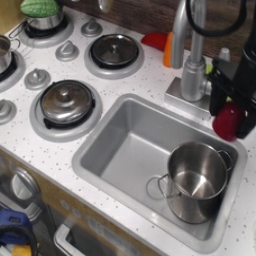

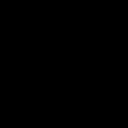

b'put sweet potato in pot which is in sink'


In [ ]:
# let's take a look at the "task" dict: it should now have both goal
# images and language instructions!
goal_primary = batch["task"]["image_primary"]
goal_wrist = batch["task"]["image_wrist"]
language_instruction = batch["task"]["language_instruction"]
display(Image.fromarray(goal_primary[0]))
display(Image.fromarray(goal_wrist[0]))
print(language_instruction[0])

# Dinov3 Stuff

In [ ]:
%reload_ext autoreload
import torch
from transformers import AutoImageProcessor, AutoModel
from transformers.image_utils import load_image

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
img = load_image(url)


dinov3_model_name = "facebook/dinov3-vith16plus-pretrain-lvd1689m"
# dinov3_model_name = "facebook/dinov3-vits16-pretrain-lvd1689m"
processor = AutoImageProcessor.from_pretrained(dinov3_model_name)
model = AutoModel.from_pretrained(
    dinov3_model_name,
    device_map="auto",
    attn_implementation="sdpa",
)

inputs = processor(images=img, return_tensors="pt").to(model.device)
with torch.inference_mode():
    outputs = model(
        **inputs,
    )

pooled_output = outputs.pooler_output


/scr/yutaizho/miniconda3/envs/ope/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scr/yutaizho/miniconda3/envs/ope/lib/python3.10/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-10-21 22:18:49.594852: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-21 22:18:49.594917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-21 22:18:49.596398: E external/local_xla/xla/stream_executor/cuda/cuda

In [ ]:
from einops import rearrange

for k, v in outputs.items():
    print(k, v.shape)

patch_size = model.config.patch_size  # 16
dim = model.config.hidden_size  # 1280
n_registers = model.config.num_register_tokens  # 4
*_, input_height, input_width = inputs["pixel_values"].shape  # (B, C, H, W)
n_patches_height = input_height // patch_size
n_patches_width = input_width // patch_size
n_patches_flat = n_patches_height * n_patches_width
assert n_patches_height == n_patches_width
print(f"Dinov3 patch size: {patch_size}")
print(
    f"Dinov3 input/output size: {input_height}x{input_width} -> {n_patches_height}x{n_patches_width} patches"
)
print(f"{n_patches_flat} patches, {n_registers} registers")

last_hidden_state = outputs["last_hidden_state"]
assert last_hidden_state.shape == (1, 1 + n_patches_flat + n_registers, dim)
cls_token = last_hidden_state[:, 0, :]  # (B, D)
patch_features_flat = last_hidden_state[:, 1 : 1 + n_patches_flat, :]  # (B, P, D)
patch_features = rearrange(
    patch_features_flat,
    "B (PH PW) D -> B PH PW D",
    PH=n_patches_height,
    PW=n_patches_width,
)
print(f"{cls_token.shape=}, {patch_features.shape=}")


"""
h5 dataset structure:
traj_idx: {
    "dinov3_embeddings": (T, D)
    "dinov3_patch_embeddings": (T, , D)
}
"""


last_hidden_state torch.Size([1, 201, 1280])
pooler_output torch.Size([1, 1280])
Dinov3 patch size: 16
Dinov3 input/output size: 224x224 -> 14x14 patches
196 patches, 4 registers
cls_token.shape=torch.Size([1, 1280]), patch_features.shape=torch.Size([1, 14, 14, 1280])


'\nh5 dataset structure:\ntraj_idx: {\n    "dinov3_embeddings": (T, D)\n    "dinov3_patch_embeddings": (T, , D)\n}\n'

In [ ]:
from einops import rearrange

traj = next(iterator)
raw_imgs = traj["observation"]["image_primary"]

print(raw_imgs.shape)  # (T, hist, H, W, C)
print(raw_imgs.dtype)
print(raw_imgs.min(), raw_imgs.max(), raw_imgs.mean())


def prepare_oxe_images(imgs):
    """
    Input: Uint8[Array, "T hist H W C"], range [0 255]
    Output: Float32[Tensor, "T C H W"] resized + ImageNet normalized
    """
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    imgs = imgs.astype(np.float32)
    imgs /= 255
    imgs = (imgs - means) / stds
    imgs = rearrange(imgs, "T 1 H W C -> T C H W")
    imgs = torch.from_numpy(imgs)
    return imgs


def unprepare_image(img):
    """
    AutoImageProcessor:
        Input: Uint8[Array, "H W C"]
        Output: Float32[Tensor, "1 C H W"] resized + ImageNet normalied

    Input torch tensor, get raw uint8 image for displayby reversing the preparation process
    """
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    img = img.cpu().numpy()  # (1, C, H, W)
    img = rearrange(img, "1 C H W -> H W C")
    img = img * stds + means
    img *= 255
    img = img.astype(np.uint8)
    return img


prepared_imgs = prepare_oxe_images(raw_imgs).to(model.device)


def get_image_stats_str(imgs):
    return f"{imgs.shape}, {imgs.dtype}, in [{imgs.min()}, {imgs.max()}]"


print(f"raw images: {get_image_stats_str(raw_imgs)}")
print(f"prepared images: {get_image_stats_str(prepared_imgs)}")
print(model(prepared_imgs)["pooler_output"].shape)

NameError: name 'iterator' is not defined

In [ ]:
traj["observation"]["image_primary"].shape

NameError: name 'traj' is not defined

In [ ]:
processed_img = processor(
    images=rearrange(raw_imgs, "T 1 H W C -> T C H W"), return_tensors="pt"
).to(model.device)["pixel_values"]

In [ ]:
print(processed_img.shape)
print(prepared_imgs.shape)

In [ ]:
model(prepared_imgs)["pooler_output"].shape

In [ ]:
import PIL

display(PIL.Image.fromarray(unprepare_image(inputs["pixel_values"])))


pooled_output = outputs.pooler_output
print("Original image shape:", np.asarray(img).shape)
print("Processed image shape:", inputs["pixel_values"].shape)  # (1, 3, 224, 224)
print("Pooled output shape:", pooled_output.shape)  # (1, 1280)


In [ ]:
print(outputs["last_hidden_state"].shape)
print(outputs["pooler_output"].shape)